# Regression Analysis for Market Predictions

> Copyright 2019 Dave Fernandes. All Rights Reserved.
> 
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
>
> http://www.apache.org/licenses/LICENSE-2.0
>  
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

## Overview
This notebook performs regression to predict stock index changes from the daily news content.
- Data for this analysis should be prepared using the `Preprocessing.ipynb` notebook from this project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import pickle

import tensorflow as tf
tf.enable_eager_execution()

### Mapping function for stock index dataset
- Includes normalization

In [2]:
STOCKS_TRAIN_RECORDS = './data/stock_train.tfrecords'
STOCKS_NORM = './data/stock_norm.py'

# Column indices for 'statistics' feature of stocks TFRecord
DAYS_SINCE_LAST_TRADE = 0  # Days elapsed since previous trading day
DAYS_UNTIL_NEXT_TRADE = 1  # Days until next trading day
OPEN_LOG_RATIO        = 2  # Log of ratio of adjusted open to previous day's adjusted close
CLOSE_LOG_RATIO       = 3  # Log of ratio of adjusted close to previous day's adjusted close
HIGH_LOG_RATIO        = 4  # Log of ratio of adjusted high to previous day's adjusted close
LOW_LOG_RATIO         = 5  # Log of ratio of adjusted low to previous day's adjusted close
VOLUME_LOG            = 6  # Log of volume
STATISTICS_COUNT      = 7

REGRESSION_LABEL_COUNT = 1

# Row indices for normalization info
MEAN_ROW    = 0
STD_DEV_ROW = 1
MAX_ROW     = 2
MIN_ROW     = 3

with open(STOCKS_NORM, 'rb') as file:
    normalization = pickle.load(file)

STOCKS_TEST_RECORDS = './data/stock_test.tfrecords'

def parse_stock_record(example):
    # Features in stocks TFRecord file
    F_DATE = 'date'               # Date label (unique; UTF-8)
    F_STATISTICS = 'statistics'   # Vector of floating point stats (see column indices below)
    F_INC_AT_OPEN  = 'open_inc'   # 1 if adjusted open price is greater than previous day's adjusted close price; 0 otherwise
    F_INC_AT_CLOSE = 'close_inc'  # 1 if close price is greater than open price; 0 otherwise

    features_desc = {
        F_DATE: tf.FixedLenFeature([], tf.string),
        F_INC_AT_OPEN: tf.FixedLenFeature([], tf.int64),
        F_INC_AT_CLOSE: tf.FixedLenFeature([], tf.int64),
        F_STATISTICS: tf.FixedLenFeature([STATISTICS_COUNT], tf.float32),
        }
    features = tf.parse_single_example(example, features=features_desc)
    
    date = features[F_DATE]
    inc_open = features[F_INC_AT_OPEN]
    inc_close = features[F_INC_AT_CLOSE]
    statistics = features[F_STATISTICS]
    
    # Normalize to zero mean and unit variance
    normed_stats = (statistics - normalization[MEAN_ROW][:STATISTICS_COUNT]) / normalization[STD_DEV_ROW][:STATISTICS_COUNT]
    
    # Regress against labels: OPEN_LOG_RATIO through LOW_LOG_RATIO elements (4 total)
    out = tf.slice(normed_stats, [CLOSE_LOG_RATIO], [REGRESSION_LABEL_COUNT])
    
    return out

### Mapping function for news dataset
- BERT feature vectors for each news story grouped by date

In [3]:
NEWS_TEST_RECORDS = './data/news_test.tfrecords'
NEWS_TRAIN_RECORDS = './data/news_train.tfrecords'
FEATURE_VECTOR_LENGTH = 768*4
FEATURE_VECTOR_COUNT = 25

def parse_news_record(example):
    # Features in news TFRecord file
    F_LENGTH = 'vector_length' # Length of each feature vector
    F_COUNT = 'vector_count'   # Count of feature vectors in list
    F_VECTORS  = 'vector_list' # List of feature vectors

    features_desc = {
        F_LENGTH: tf.FixedLenFeature([], tf.int64),
        F_COUNT: tf.FixedLenFeature([], tf.int64),
        F_VECTORS: tf.FixedLenFeature([FEATURE_VECTOR_COUNT, FEATURE_VECTOR_LENGTH], tf.float32),
        }
    features = tf.parse_single_example(example, features=features_desc)
    
    v_length = features[F_LENGTH]
    v_count = features[F_COUNT]
    v_list = features[F_VECTORS]
    
    return {'news_embedding': v_list}

### Input functions for Estimator

In [4]:
def train_input_fn():
    news_train_set = tf.data.TFRecordDataset([NEWS_TRAIN_RECORDS]).map(parse_news_record)
    stock_train_set = tf.data.TFRecordDataset([STOCKS_TRAIN_RECORDS]).map(parse_stock_record)
    train_set = tf.data.Dataset.zip((news_train_set, stock_train_set)).repeat().shuffle(10000).batch(200)
    return train_set

def train_plot_input_fn():
    news_train_set = tf.data.TFRecordDataset([NEWS_TRAIN_RECORDS]).map(parse_news_record)
    stock_train_set = tf.data.TFRecordDataset([STOCKS_TRAIN_RECORDS]).map(parse_stock_record)
    train_set = tf.data.Dataset.zip((news_train_set, stock_train_set)).batch(2000)
    return train_set

def test_input_fn():
    news_test_set = tf.data.TFRecordDataset([NEWS_TEST_RECORDS]).map(parse_news_record)
    stock_test_set = tf.data.TFRecordDataset([STOCKS_TEST_RECORDS]).map(parse_stock_record)
    test_set = tf.data.Dataset.zip((news_test_set, stock_test_set)).batch(1000)
    return test_set

### Define model

In [5]:
def news_model_fn(features, labels, mode, params):
    current_layer = tf.feature_column.input_layer(features, params['feature_columns'])
    current_layer = tf.expand_dims(tf.layers.flatten(current_layer, name='flatten_input'), -1)
    
    for i, units in enumerate(params['conv_filters']):
        if i == 0:
            kernel_size = FEATURE_VECTOR_LENGTH,
            strides = FEATURE_VECTOR_LENGTH,
        else:
            kernel_size = 1,
            strides = 1,
            
        current_layer = tf.layers.conv1d(current_layer,
            name='conv1d_' + str(i+1),
            filters=units,
            data_format='channels_last',
            kernel_size=kernel_size,
            strides=strides,
            padding='valid',
            kernel_initializer=tf.glorot_normal_initializer(),
            kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
            bias_regularizer=tf.keras.regularizers.l2(l=0.01),
            activation=tf.nn.tanh)

    current_layer = tf.layers.max_pooling1d(current_layer,
        pool_size=FEATURE_VECTOR_COUNT,
        strides=1,
        padding='valid',
        data_format='channels_last')

    current_layer = tf.layers.flatten(current_layer)
    
    for i, units in enumerate(params['hidden_units']):
        current_layer = tf.layers.dense(current_layer,
            name='dense_' + str(i+1),
            units=units,
            kernel_initializer=tf.glorot_normal_initializer(),
            kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
            bias_regularizer=tf.keras.regularizers.l2(l=0.01),
            activation=tf.nn.tanh)

    regression_layer = tf.layers.dense(current_layer,
        name='linear_output',
        units=REGRESSION_LABEL_COUNT,
        kernel_initializer=tf.glorot_normal_initializer(),
        kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
        bias_regularizer=tf.keras.regularizers.l2(l=0.01),
        activation=None)

    # For prediction, exit here
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'predictions': regression_layer,
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # For training and evaluation, compute the loss (MSE)
    loss = tf.losses.mean_squared_error(labels, regression_layer)

    abs_error = tf.metrics.mean_tensor(tf.reduce_mean(tf.abs(labels - regression_layer), axis=0))
    metrics = {'abs_error': abs_error}
    tf.summary.tensor_summary('abs_error', abs_error)

    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=metrics)

    # For training...
    optimizer = tf.train.AdagradOptimizer(learning_rate=0.01)
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

### Train model

In [6]:
MODEL_DIR = './data/Regression'

feature_columns = [tf.feature_column.numeric_column('news_embedding', [FEATURE_VECTOR_COUNT, FEATURE_VECTOR_LENGTH])]

regressor = tf.estimator.Estimator(
    model_fn=news_model_fn,
    model_dir=MODEL_DIR,
    params={
        'feature_columns': feature_columns,
        'conv_filters': [300, 30],
        'hidden_units': [30, 8],
    })

regressor.train(train_input_fn, steps=2000)

info = regressor.evaluate(input_fn=test_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './data/Regression', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0xb3d209080>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was 

### Plot the predictions

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./data/Regression/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


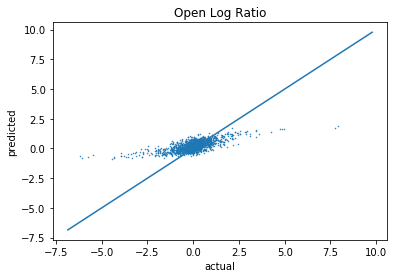

In [9]:
dataset_fn = train_plot_input_fn

predictions = regressor.predict(input_fn=dataset_fn)
dataset = dataset_fn()
actual = []
predicted = []

for i, value in enumerate(predictions):
    predicted.append(value['predictions'])
    
for x, y in dataset.take(2000):
    actual = y.numpy()

actual = np.reshape(actual, (len(actual), REGRESSION_LABEL_COUNT))
predicted = np.reshape(predicted, (len(predicted), REGRESSION_LABEL_COUNT))

titles = ['Open', 'Close', 'High', 'Low']

for offset in range(REGRESSION_LABEL_COUNT):
    maximum = max(actual[:, offset] + predicted[:, offset])
    minimum = min(actual[:, offset] + predicted[:, offset])
    plt.plot([minimum,maximum],[minimum,maximum])
    
    plt.scatter(actual[:, offset], predicted[:, offset], marker='.', s=1)
    
    plt.ylabel('predicted')
    plt.xlabel('actual')
    plt.title(titles[offset] + ' Log Ratio')
    plt.show()

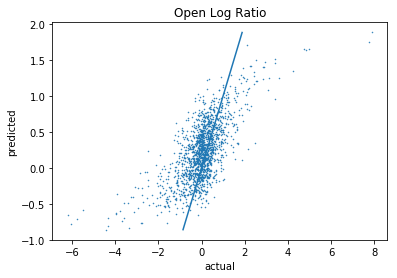

In [10]:
for offset in range(REGRESSION_LABEL_COUNT):
    maximum = max(predicted[:, offset])
    minimum = min(predicted[:, offset])
    plt.plot([minimum,maximum],[minimum,maximum])
    
    plt.scatter(actual[:, offset], predicted[:, offset], marker='.', s=1)
    
    plt.ylabel('predicted')
    plt.xlabel('actual')
    plt.title(titles[offset] + ' Log Ratio')
    plt.show()